### Import packages

In [1]:
import sys
import pandas as pd
print(pd.__version__)
import os
import torch as th
import numpy as np
import gymnasium as gym
print(gym.__version__)
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta

import stable_baselines3
print(stable_baselines3.__version__)



2.2.2
0.29.1
2.3.2


In [2]:
# Setting all debugging flags to False
DEBUG_MODE = False 
DEBUG_MODE_TRAINING = False 
DEBUG_MODE_REWARD = False  


### Hyperparameters

In [3]:
print_train_hyperparams()

N_EPISODES = 1000           # number of episodes PER TRAINING SCENARIO
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256*4, 256])  
TRAINING_FOLDERS_PATH = '../data/Training'

# Verify folders exists
if not os.path.exists(TRAINING_FOLDERS_PATH):
    raise FileNotFoundError(f'Training folder not found at {TRAINING_FOLDERS_PATH}')

# print all folders in the training folder
training_folders = []
for folder in os.listdir(TRAINING_FOLDERS_PATH):
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder)):
        training_folders.append(folder)

num_days_trained_on = N_EPISODES * len(training_folders)
print(f'Training on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)')

model_name = 'dqn_' + str(num_days_trained_on) + "d_" + str(len(training_folders)) + "u"
print('Model name:', model_name)
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = '../trained_models/' + model_name + '-' + model_version + '.zip'

print('Model will be saved to:', MODEL_SAVE_PATH)

LEARNING_RATE: 0.001
GAMMA: 0.99
BUFFER_SIZE: 50000
BATCH_SIZE: 32
TARGET_UPDATE_INTERVAL: 100
EPSILON_START: 1.0
EPSILON_MIN: 0.05
EPSILON_DECAY_RATE: 0.0005
MAX_TIMESTEPS: 500

Training on 10000 days of data (10 unique scenarios)
Model name: dqn_10000d_10u
Model will be saved to: ../trained_models/dqn_10000d_10u-1.zip


# Reinforcement Learning

## Environment

In [4]:
from src.environment import AircraftDisruptionEnv

## Loading Scenario

## Training

In [5]:
rewards = []
epsilon_values = []

def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [os.path.join(TRAINING_FOLDERS_PATH, folder) for folder in os.listdir(TRAINING_FOLDERS_PATH) if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))]
    
    total_timesteps = 0
    epsilon = EPSILON_START

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)

            # Extract necessary data for the environment
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Initialize the environment with the current scenario
            env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
            env = DummyVecEnv([lambda: env])

            # Initialize the DQN model with the custom policy and feature extractor
            model = DQN(
                policy='MlpPolicy',
                env=env,
                learning_rate=LEARNING_RATE,
                gamma=GAMMA,
                buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE,
                target_update_interval=TARGET_UPDATE_INTERVAL,
                verbose=1,
                policy_kwargs=NEURAL_NET_STRUCTURE
            )


            # Verify the policy and feature extractor
            # print(f"Using policy: {model.policy}")
            # print(f"Using feature extractor: {model.policy.features_extractor}")

            # Reset the environment
            obs = env.reset()
            # print(f"Observation after reset: {obs}")

            done = False
            total_reward = 0
            timesteps = 0

            while not done and timesteps < MAX_TIMESTEPS:
                
                obs_input = obs[0]

                # Print all possible actions in a list in one line
                if DEBUG_MODE_TRAINING:
                    print("possible actions: ", list(range(env.action_space.n)))

                model.exploration_rate = epsilon
                action, _ = model.predict(obs, deterministic=False)

                action = np.array([action])  # Wrap action in an array
                result = env.step(action)

                if len(result) == 4:
                    obs, reward, done, info = result
                    terminated = done  # Old-style "done" flag
                    truncated = False
                else:
                    obs, reward, terminated, truncated, info = result
                    done = terminated or truncated  # Combine terminated and truncated to form done

                if DEBUG_MODE_TRAINING:
                    print("=== chosen action: ", action)
                    print("Action type after predict:", type(action))
                    print("Observation type:", type(obs), "Observation shape:", obs.shape)

                # q_values = model.policy.q_net(th.tensor(obs, dtype=th.float32).to(model.device)).detach().cpu().numpy()
                # print("Q-values: ", q_values)
                # Step the environment

                # Combine terminated and truncated to form done
                done = terminated or truncated

                obs = obs[0]
                reward = reward[0]
                # done = done[0]
                info = info[0]

                # Accumulate the reward
                total_reward += reward

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                obs_tensor = th.tensor(obs_input, dtype=th.float32).to(model.device)
                if len(obs_tensor.shape) == 1:
                    obs_tensor = obs_tensor.unsqueeze(0)  # Add batch dimension
                # q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy()
                # print("Q-values: ", q_values)

                timesteps += 1
                total_timesteps += 1

                if DEBUG_MODE_REWARD:
                    print(" action chosen ", action)
            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))
            
            print(f"Episode {episode}, Scenario {scenario_folder}, Total Reward: {total_reward}")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)

# Run the training process
train_dqn_agent()


Using cpu device
Episode 0, Scenario ../data/Training/Scenario_03, Total Reward: 1813.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_04, Total Reward: 1623.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_05, Total Reward: 899.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_02, Total Reward: 788.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_10, Total Reward: 1732.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_09, Total Reward: 1691.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_07, Total Reward: -314.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_01, Total Reward: 827.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_06, Total Reward: 665.0
Using cpu device
Episode 0, Scenario ../data/Training/Scenario_08, Total Reward: 882.0
Using cpu device
Episode 1, Scenario ../data/Training/Scenario_03, Total Reward: 1545.0
Using cpu device
Episode 1, Scenario 

Trained on 10000 days of data (10 unique scenarios)


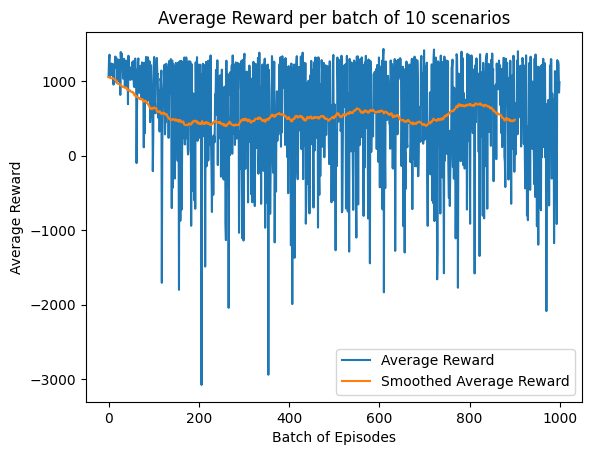

In [6]:
print(f"Trained on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)")

avg_rewards = []

# amount of scenarios:
num_scenarios = len(training_folders)

# Average reward for every iteration of the 10 scenarios
for i in range(0, len(rewards), len(training_folders)):
    avg_rewards.append(np.mean([reward for _, _, reward in rewards[i:i+num_scenarios]]))
    
# Smooth the average rewards
window = 100
smoothed_avg_rewards = np.convolve(avg_rewards, np.ones(window)/window, mode='valid')

# Plot the average rewards over the episodes
plt.plot(range(N_EPISODES), avg_rewards)
plt.plot(range(N_EPISODES - window + 1), smoothed_avg_rewards, label='Smoothed')
# legend
plt.legend(['Average Reward', 'Smoothed Average Reward'])
plt.xlabel('Batch of Episodes')
plt.ylabel('Average Reward')
plt.title(f'Average Reward per batch of {num_scenarios} scenarios')
plt.show()


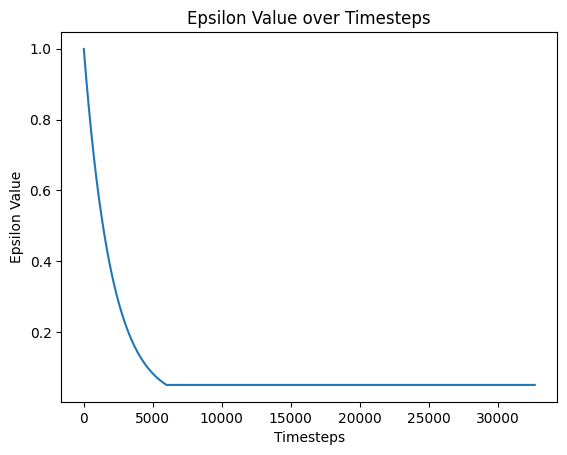

In [7]:
# Plot the epsilon values over the episodes
plt.plot(range(len(epsilon_values)), epsilon_values)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps')
plt.show()